<a href="https://colab.research.google.com/github/LeoFernanndes/notebooks/blob/master/titanic_data_manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!git clone https://github.com/LeoFernanndes/functions

fatal: destination path 'functions' already exists and is not an empty directory.


In [0]:
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


url_train = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_%20train.csv'
url_test = 'https://raw.githubusercontent.com/LeoFernanndes/datasets/master/titanic_test.csv'

columns_order = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

train = pd.read_csv(url_train).reindex(columns_order, axis= 1)
test = pd.read_csv(url_test).reindex(columns_order.remove('Survived'), axis= 1)

dataframe = train.append(test, sort= False).set_index(np.arange(0,1309), columns_order)
backup = dataframe.copy()
dataframe_ = dataframe.iloc[:891]

In [28]:
backup

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,1.0
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,1.0
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,0.0
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0.0
6,7,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S,0.0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,0.0
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S,1.0
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C,1.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


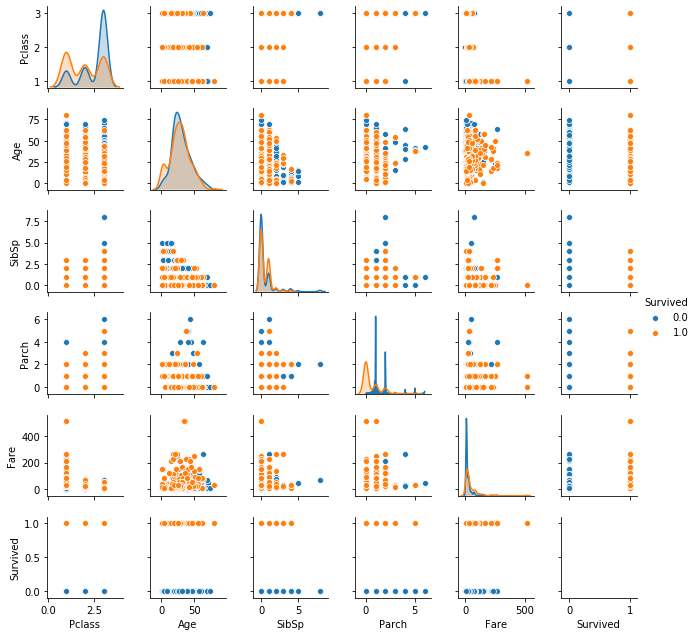

In [29]:
colunas = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

data = backup[colunas]


import seaborn as sns      
sns.pairplot(data, hue='Survived', size=1.5)

In [30]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

for feature in features:
  print(dataframe_.groupby(by= [feature]).mean()['Survived'].sort_values(ascending= False), '\n')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 

SibSp
1    0.535885
2    0.464286
0    0.345395
3    0.250000
4    0.166667
8    0.000000
5    0.000000
Name: Survived, dtype: float64 

Parch
3    0.600000
1    0.550847
2    0.500000
0    0.343658
5    0.200000
6    0.000000
4    0.000000
Name: Survived, dtype: float64 

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64 



In [0]:
# data cleaning and feature engineering


dataframe['Family'] = dataframe['Parch'] + dataframe['SibSp']



family_dict = {7: 0, 10: 0,
               5: 1, 4: 1,
               0: 2, 6: 2,
               1: 3, 2: 3, 3: 3}

dataframe['Family_'] = dataframe['Family'].map(family_dict)



dataframe['Sex'] = dataframe['Sex'].map({'female': 1,
                                         'male': 0})



dataframe['Fare'].fillna(dataframe['Fare'].median(), inplace= True)
dataframe['Embarked'].fillna('S', inplace= True)
dataframe['Cabin'].fillna('Unknown', inplace= True)
dataframe['Title'] = [name.split(',')[1].split('.')[0] for name in dataframe['Name']]
dataframe['Pclass'] = dataframe['Pclass'].fillna(dataframe['Pclass'].mode())
dataframe['Pclass_'] = dataframe['Pclass'].map({1: 3,
                                                2: 2,
                                                3: 1})


ages = dataframe.groupby(by= ['Title']).mean()['Age']
for title in ages.index:
  mask = dataframe['Title'] == title
  dataframe.loc[mask, 'Age'] = dataframe.loc[mask, 'Age'].fillna(value= dataframe.loc[dataframe['Title'] == title]['Age'].mean())



title_dict = {' Capt': 0, ' Don': 0, ' Jonkheer': 0, ' Rev': 0,
              ' Mr': 1, 'Dr': 1, ' Col': 1, ' Major': 1, ' Master': 1, ' Dona': 1,
              ' Miss': 2, ' Mrs': 2, ' Mme': 2, ' Sir': 2, ' Ms': 2, ' Lady': 2, ' Mlle': 2, ' the Countess': 2}

dataframe['Title_n'] = dataframe['Title'].copy().map(title_dict)



bins = [0, 12, 24, 45, 60, dataframe['Age'].max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
dataframe['Age_'] = pd.cut(dataframe["Age"], bins, labels = labels)



bins = [0, 8, 16, 24, 32, dataframe['Fare'].max()]
labels = ['low_price', 'tier2', 'tier3','tier4','high_price']
dataframe['Fare_'] = pd.cut(dataframe['Fare'], bins, labels = labels)

In [32]:
dataframe.dtypes
dataframe.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Family,Family_,Title,Pclass_,Title_n,Age_,Fare_
0,1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,Unknown,S,0.0,1,3,Mr,1,1.0,Young Adult,low_price
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,3,Mrs,3,2.0,Adult,high_price
2,3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,1.0,0,2,Miss,1,2.0,Adult,low_price


In [0]:
from functions import data_preprocessing


data_preprocessing.naive_data_preparation(dataframe)
#datraframe_ = dataframe.copy().loc[(dataframe['Survived'] == 1) | (dataframe['Survived'] == 0)]

In [34]:
dataframe.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Family,Family_,Title,Pclass_,Title_n,Age_,Fare_
0,1,3,155,0,22.0,1,0,720,7.2500,186,2,0.0,1,3,12,1,1.0,4,1
1,2,1,286,1,38.0,1,0,816,71.2833,106,0,1.0,1,3,13,3,2.0,0,0


In [35]:
from sklearn.model_selection import cross_val_score
from xgboost  import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


'''
colunas = ['Sex', 'Ticket', 'Age', 'Fare', 'Name', 'PassengerId', 'Title',
       'Title_n', 'Cabin', 'Pclass', 'Fare_', 'Pclass_', 'Family',
       'Family_', 'Age_', 'SibSp', 'Embarked', 'Parch', 'Survived']

colunas = ['Fare_', 'Age_', 'Title_n', 'Pclass_','Family_', 'Survived']       
'''
colunas = ['Sex', 'Ticket', 'Age', 'Fare', 'Name', 'PassengerId', 'Title',
       'Title_n', 'Cabin', 'Pclass', 'Fare_', 'Pclass_', 'Family',
       'Family_', 'Age_', 'SibSp', 'Embarked', 'Parch', 'Survived']


dataframe = dataframe.reindex(colunas, axis= 1)


dataframe_ = dataframe.iloc[:891]

clf = RandomForestClassifier(n_estimators= 100)

cross_val_score(clf,dataframe_[dataframe_.columns[:-1]], dataframe_['Survived'], cv= 10)

array([0.82222222, 0.85555556, 0.74157303, 0.86516854, 0.88764045,
       0.85393258, 0.85393258, 0.80898876, 0.85393258, 0.85227273])

In [36]:
dataframe_.head(2)

,Sex,Ticket,Age,Fare,Name,PassengerId,Title,Title_n,Cabin,Pclass,Fare_,Pclass_,Family,Family_,Age_,SibSp,Embarked,Parch,Survived
0,0,720,22.0,7.2500,155,1,12,1.0,186,3,1,1,1,3,4,1,2,0,0.0
1,1,816,38.0,71.2833,286,2,13,2.0,106,1,0,3,1,3,0,1,0,0,1.0


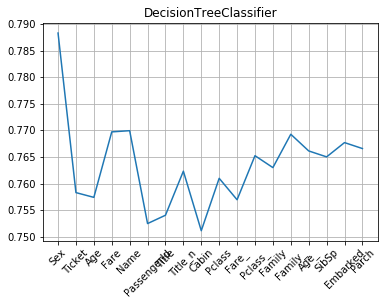

In [37]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


clf = DecisionTreeClassifier()

data_preprocessing.classifier_accuracy_graph(dataframe_, clf, iterations= 20)

In [0]:
clf = DecisionTreeClassifier(max_depth= 5)
clf.fit(dataframe_[dataframe_.columns[:-1]], dataframe_['Survived'])

y_pred = clf.predict(dataframe[dataframe.columns[:-1]].iloc[891:])

In [0]:
pd.Series(y_pred).map({0.:0, 1.:1})
y_pred = pd.Series(y_pred).map({0.:0, 1.:1})
y_pred = list(y_pred)

In [40]:
df_featimp = pd.DataFrame({'feature': dataframe.columns[:-1],
                           'importance': clf.feature_importances_}).sort_values(by= ['importance'], ascending= False)

df_featimp['feature'].unique()                      

array(['Sex', 'Pclass_', 'Family_', 'Age', 'Cabin', 'Name', 'Ticket',
       'Embarked', 'Fare', 'Family', 'SibSp', 'Age_', 'Pclass', 'Fare_',
       'Title_n', 'Title', 'PassengerId', 'Parch'], dtype=object)

In [0]:
envio = pd.DataFrame({'PassengerId': backup.iloc[891:]['PassengerId'],
                      'Survived': y_pred}).set_index(['PassengerId'])

from google.colab import files


envio.to_csv('titanic_submission_5.csv')

In [42]:
dataframe

,Sex,Ticket,Age,Fare,Name,PassengerId,Title,Title_n,Cabin,Pclass,Fare_,Pclass_,Family,Family_,Age_,SibSp,Embarked,Parch,Survived
0,0,720,22.000000,7.2500,155,1,12,1.000000,186,3,1,1,1,3,4,1,2,0,0.000000
1,1,816,38.000000,71.2833,286,2,13,2.000000,106,1,0,3,1,3,0,1,0,0,1.000000
2,1,914,26.000000,7.9250,523,3,9,2.000000,186,3,1,1,0,2,0,0,2,0,1.000000
3,1,65,35.000000,53.1000,422,4,13,2.000000,70,1,0,3,1,3,0,1,2,0,1.000000
4,0,649,35.000000,8.0500,22,5,12,1.000000,186,3,3,1,0,2,0,0,2,0,0.000000
5,0,373,32.252151,8.4583,818,6,12,1.000000,186,3,3,1,0,2,0,0,1,0,0.000000
6,0,109,54.000000,51.8625,767,7,12,1.000000,163,1,0,3,0,2,2,0,2,0,0.000000
7,0,541,2.000000,21.0750,914,8,8,1.000000,186,3,4,1,4,1,1,3,2,1,0.000000
8,1,477,27.000000,11.1333,605,9,13,2.000000,186,3,3,1,2,3,0,0,2,2,1.000000
9,1,174,14.000000,30.0708,847,10,13,2.000000,186,2,5,2,1,3,4,1,0,0,1.000000


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier


dataframe_stack = dataframe.copy()
dataframe_stack_train = dataframe_stack.iloc[0:700]
dataframe_stack_test = dataframe_stack.iloc[700: 891]
dataframe_stack_submit = dataframe_stack.iloc[891:]


colunas = ['Sex', 'Ticket', 'Age', 'Fare', 'Name', 'PassengerId', 'Title',
       'Title_n', 'Cabin', 'Pclass', 'Fare_', 'Pclass_', 'Family',
       'Family_', 'Age_', 'SibSp', 'Embarked', 'Parch', 'Survived']


df_stack_train = pd.DataFrame({'PassengerId': dataframe_stack_train['PassengerId']}).set_index(['PassengerId'])
df_stack_test = pd.DataFrame({'PassengerId': dataframe_stack_test['PassengerId']}).set_index(['PassengerId'])
df_stack_submit = pd.DataFrame({'PassengerId': dataframe_stack_submit['PassengerId']}).set_index(['PassengerId'])


classifiers = [AdaBoostClassifier(n_estimators=500),
               ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=500, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=500)]


iterations = 5


# training stage 
for model in classifiers:
  for n in range(iterations):  

    x_train, x_test, y_train, y_test = train_test_split(dataframe_stack_train[colunas[:-1]], dataframe_stack_train[colunas[-1]], test_size= 0.5, random_state= (n+1)**2)


    clf.fit(x_train, y_train)

    
    clf_ = clf.predict(dataframe_stack_test[colunas[:-1]])
    clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_test.index)
    df_stack_test = pd.concat([df_stack_test, clf_dataframe_], axis= 1)


mean = df_stack_test.mean(axis= 1)
mode = df_stack_test.mode(axis= 1)


f1_score_ = f1_score(mode, dataframe_stack_test['Survived'])
accuracy_score_ = accuracy_score(mode, dataframe_stack_test['Survived'])


# submission classification stage
for model in classifiers:
  for n in range(iterations):  

    
    clf.fit(dataframe_stack_train[colunas[:-1]], dataframe_stack_train['Survived'])

    
    clf_ = clf.predict(dataframe_stack_submit[colunas[:-1]])
    clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_submit.index)
    df_stack_submit = pd.concat([df_stack_submit, clf_dataframe_], axis= 1)


mean_submission = df_stack_submit.mean(axis= 1)
mode_submission = df_stack_submit.mode(axis= 1)


print('Accuracy: {}, f1_score: {}'.format(accuracy_score_, f1_score_))

Accuracy: 0.8586387434554974, f1_score: 0.7804878048780487


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier


dataframe_stack = dataframe.copy()
dataframe_stack_train = dataframe_stack.iloc[0:700]
dataframe_stack_test = dataframe_stack.iloc[700: 891]
dataframe_stack_submit = dataframe_stack.iloc[891:]


colunas = ['Sex', 'Ticket', 'Age', 'Fare', 'Name', 'PassengerId', 'Title',
       'Title_n', 'Cabin', 'Pclass', 'Fare_', 'Pclass_', 'Family',
       'Family_', 'Age_', 'SibSp', 'Embarked', 'Parch', 'Survived']


df_stack_train = pd.DataFrame({'PassengerId': dataframe_stack_train['PassengerId']}).set_index(['PassengerId'])
df_stack_test = pd.DataFrame({'PassengerId': dataframe_stack_test['PassengerId']}).set_index(['PassengerId'])
df_stack_submit = pd.DataFrame({'PassengerId': dataframe_stack_submit['PassengerId']}).set_index(['PassengerId'])


classifiers = [AdaBoostClassifier(n_estimators=500),
               ExtraTreesClassifier(n_estimators=500, n_jobs=-1, criterion='gini',max_depth=5),
               XGBClassifier(n_estimators=500, nthread=-1, max_depth = 5, seed=1729),
               GradientBoostingClassifier(n_estimators=500)]


iterations = 30


# training stage 
for model in classifiers:
  for n in range(iterations):  

    x_train, x_test, y_train, y_test = train_test_split(dataframe_stack_train[colunas[:-1]], dataframe_stack_train[colunas[-1]], test_size= 0.5, random_state= (n+1)**2)


    clf.fit(x_train, y_train)

    
    clf_ = clf.predict(dataframe_stack_test[colunas[:-1]])
    clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_test.index)
    df_stack_test = pd.concat([df_stack_test, clf_dataframe_], axis= 1)


mean = df_stack_test.mean(axis= 1)
mode = df_stack_test.mode(axis= 1)


f1_score_ = f1_score(mode[0], dataframe_stack_test['Survived'])
accuracy_score_ = accuracy_score(mode[0], dataframe_stack_test['Survived'])


# submission classification stage
for model in classifiers:
  for n in range(iterations):  

    
    clf.fit(dataframe_stack_train[colunas[:-1]], dataframe_stack_train['Survived'])

    
    clf_ = clf.predict(dataframe_stack_submit[colunas[:-1]])
    clf_dataframe_ = pd.DataFrame({n: clf_}, index= df_stack_submit.index)
    df_stack_submit = pd.concat([df_stack_submit, clf_dataframe_], axis= 1)


mean_submission = df_stack_submit.mean(axis= 1)
mode_submission = df_stack_submit.mode(axis= 1)


submission = list(mode_submission[0].map({0.0: 0, 1.0: 1}))
envio = pd.DataFrame({'PassengerId': dataframe_stack_submit['PassengerId'],
                      'Survived': submission}).set_index(['PassengerId'])

from google.colab import files


envio.to_csv('titanic_submission_5.csv')

print('Accuracy: {}, f1_score: {}'.format(accuracy_score_, f1_score_))

Accuracy: 0.8481675392670157, f1_score: 0.7819548872180452
